In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from IPython.display import Image
from sklearn.metrics import log_loss
import seaborn as sns

In [2]:
df = pd.read_csv("df_high_and_low.csv")

In [3]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [4]:
df["Particle"].value_counts()

ele_high     109
ele_low      105
muon         104
pion_low     104
pion_high    103
Name: Particle, dtype: int64

### Building the classifier:


In [43]:
def ModelDecisionTree(df):

    def split_dataset_stratified(df):
        # Separating the target variable
        X = df.drop("Particle", inplace=False, axis=1)
        Y = df["Particle"]
        X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                            test_size = 0.3,
                                                            random_state = 100,
                                                            shuffle = True, stratify = Y)
        return X, Y, X_train, X_test, y_train, y_test


    def train(X_train, X_test, y_train):
        # Creating the classifier object
        clf = DecisionTreeClassifier(criterion="gini",
                                          random_state=100,
                                          max_depth=3, min_samples_leaf=5)

        # Performing training
        clf.fit(X_train, y_train)
        return clf

    def prediction(X_test, clf_object):
        # Predicton on test with giniIndex
        y_pred = clf_object.predict(X_test)
        indices = list(X_test.index)
        data = {"Index": indices, "Prediction": y_pred}
        y_pred_df = pd.DataFrame(data=data)
        return y_pred, y_pred_df

    def cal_accuracy(y_test, y_pred):
        print("Confusion Matrix: \n",
              confusion_matrix(y_test, y_pred))
        print("Report : ",
              classification_report(y_test, y_pred))

    # Building Phase
    data = df
    X, y, X_train, X_test, y_train, y_test = split_dataset_stratified(data)
    clf = train(X_train, X_test, y_train)
    # Operational Phase
    print("Predictions:")

    # Prediction
    y_pred, y_pred_df = prediction(X_test, clf)
    print(y_test.shape, y_pred.shape)
    y_test_df = pd.DataFrame(y_test)

    cal_accuracy(y_test, y_pred)
    print()
    features = [f for f in X_train.columns]
    feature_importance_df = pd.DataFrame()
    feature_importance_df["feature"] = features
    feature_importance_df["importance"] = clf.feature_importances_
    return y_test_df, y_pred_df, feature_importance_df

In [44]:
def DisplayImportances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Decision Tree Features')
    plt.tight_layout()
    plt.savefig('importances01.png')

### Training the tree and getting the results

In [45]:
y_test, y_pred, feature_importance_df = ModelDecisionTree(df)

Predictions:
(158,) (158,)
Confusion Matrix: 
 [[33  0  0  0  0]
 [ 0 30  2  0  0]
 [ 0  0 30  0  1]
 [ 1  0  1 28  1]
 [ 0  1 27  1  2]]
Report :                precision    recall  f1-score   support

    ele_high       0.97      1.00      0.99        33
     ele_low       0.97      0.94      0.95        32
        muon       0.50      0.97      0.66        31
   pion_high       0.97      0.90      0.93        31
    pion_low       0.50      0.06      0.11        31

    accuracy                           0.78       158
   macro avg       0.78      0.77      0.73       158
weighted avg       0.78      0.78      0.73       158




According to these results, the model's having serious difficulty distinguishing between the muons and low energy pions. We want to check and see samples from mislabeled data.

### Comparing the predictions and the actual results

In [48]:
y_test.reset_index(inplace=True)

In [53]:
y_test.rename(columns = {"index": "Index"}, inplace = True)

In [54]:
y_test

,Index,Particle
0,489,pion_low
1,481,pion_low
2,168,pion_high
3,224,muon
4,147,pion_high
...,...,...
153,115,pion_high
154,173,pion_high
155,98,ele_high
156,494,pion_low


In [47]:
y_pred

,Index,Prediction
0,489,muon
1,481,muon
2,168,ele_high
3,224,muon
4,147,pion_high
...,...,...
153,115,pion_high
154,173,pion_high
155,98,ele_high
156,494,muon


In [76]:
y_merged = pd.merge(y_test, y_pred, on="Index")

In [77]:
y_merged

,Index,Particle,Prediction
0,489,pion_low,muon
1,481,pion_low,muon
2,168,pion_high,ele_high
3,224,muon,muon
4,147,pion_high,pion_high
...,...,...,...
153,115,pion_high,pion_high
154,173,pion_high,pion_high
155,98,ele_high,ele_high
156,494,pion_low,muon


In [82]:
mislabeled_events = []
for i in range(len(y_merged)):
    if y_merged.loc[i]["Particle"] != y_merged.loc[i]["Prediction"]:
        mislabeled_events.append(y_merged.loc[i]["Index"])

In [83]:
mislabeled_events_df = df.loc[mislabeled_events]

In [84]:
mislabeled_events_df.reset_index(inplace=True)

In [90]:
mislabeled_events_df.rename(columns={"index": "Index"}, inplace=True)

In [91]:
mislabeled_events_df = pd.merge(mislabeled_events_df, y_pred, on="Index")

In [92]:
mislabeled_events_df

,Index,Layer1,Layer2,Layer3,Layer4,Layer5,Layer6,Layer7,Layer8,Layer9,...,Layer33,Layer34,Layer35,Layer36,Layer37,Layer38,Layer39,Layer40,Particle,Prediction
0,489,1.020180,1.527440,1.166720,13.582300,47.147500,96.049700,133.001000,97.230800,85.916000,...,14.67440,25.57020,8.96089,9.47469,2.90159,0.000000,0.000000,0.000000,pion_low,muon
1,481,0.828287,6.312640,30.079700,68.308000,44.258400,511.353000,81.669400,60.796200,64.471500,...,7.67216,5.41289,7.38145,8.69731,9.93921,0.966659,0.000000,0.000000,pion_low,muon
2,168,377.057000,57.130800,104.861000,146.437000,479.447000,491.277000,488.063000,759.561000,1211.620000,...,204.12300,39.71470,15.61220,33.05440,8.11364,0.930080,0.000000,1.728340,pion_high,ele_high
3,413,5.201580,2.076530,0.956846,2.229970,1.014260,0.883471,1.050340,3.088990,1.166360,...,12.33290,4.71772,5.09536,9.06311,4.77653,0.972806,0.000000,0.000000,pion_low,muon
4,502,2.613890,1.380710,1.982950,1.425610,1.359260,0.924484,0.000000,1.846300,1.343710,...,4.50577,10.28590,10.04120,6.99572,8.08073,1.048930,1.063360,4.002330,pion_low,muon
5,454,145.784000,41.934400,62.319300,33.193900,23.201900,29.857300,16.034500,5.902920,4.138280,...,14.94380,7.64182,14.92980,4.96183,3.80567,0.887533,0.000000,0.000000,pion_low,ele_low
6,419,0.757048,61.179700,82.412800,56.246600,21.840600,28.868200,39.991900,15.714200,40.673300,...,5.20155,4.14431,17.61040,5.99358,5.73675,0.000000,0.000000,0.000000,pion_low,muon
7,523,1.136620,2.704070,1.755330,0.839221,1.157250,0.923178,2.456610,2.353020,1.291740,...,4.73139,9.86633,7.13983,7.76033,3.61603,0.000000,0.000000,0.816375,pion_low,muon
8,284,1.057220,1.538280,1.050490,1.533190,3.637990,0.989049,1.751650,1.084330,0.978782,...,15.42560,7.69472,14.90430,22.06300,8.79396,2.040970,1.230770,0.788855,muon,pion_low
9,432,1.172300,1.214940,0.925375,1.138510,1.891810,0.930676,0.928621,3.741020,6.105320,...,10.33210,6.32516,8.50436,12.76460,12.54200,0.000000,0.000000,0.000000,pion_low,muon


In [112]:
def EnergyPlotter(df):
    layer_energies = df.drop(["Particle","Prediction", "Index"], axis=1, inplace=False)  
    for i in range(len(df)):
        plt.bar(x = np.array(range(1, 41)), height = np.array(layer_energies.loc[i]))
        plt.xlabel("Layers")
        plt.ylabel("Energy")
        plt.title("Energy per Layer (MIP) graph for: \n Particle: {particle} \n Prediction: {prediction} \n Index: {index}".format(
            particle = df.loc[i]["Particle"], prediction = df.loc[i]["Prediction"], index =df.loc[i]["Index"]))
        print("-"*110)
        plt.show()

--------------------------------------------------------------------------------------------------------------


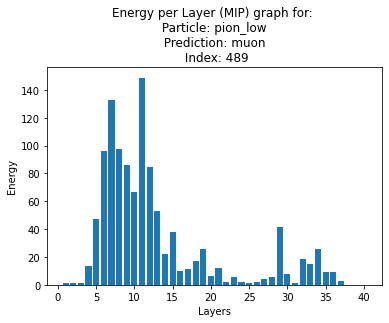

--------------------------------------------------------------------------------------------------------------


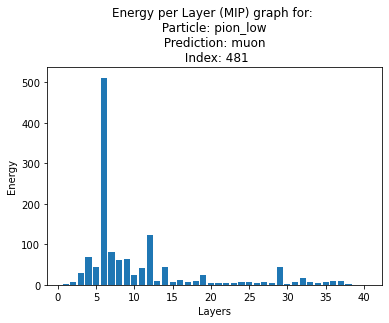

--------------------------------------------------------------------------------------------------------------


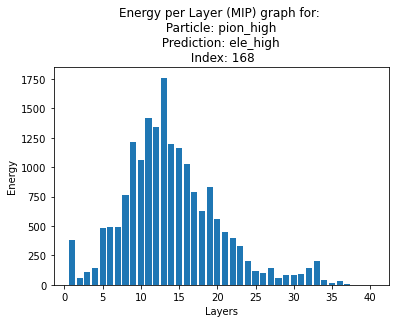

--------------------------------------------------------------------------------------------------------------


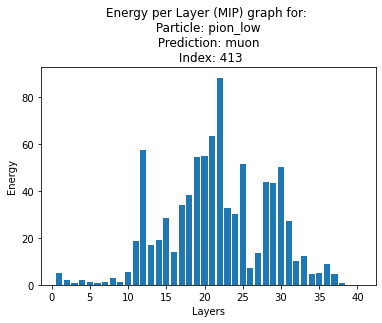

--------------------------------------------------------------------------------------------------------------


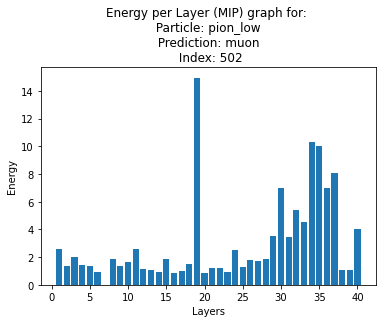

--------------------------------------------------------------------------------------------------------------


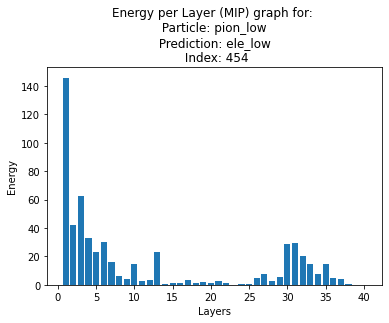

--------------------------------------------------------------------------------------------------------------


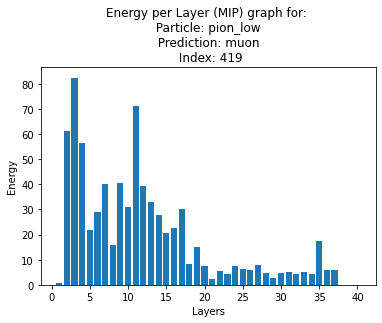

--------------------------------------------------------------------------------------------------------------


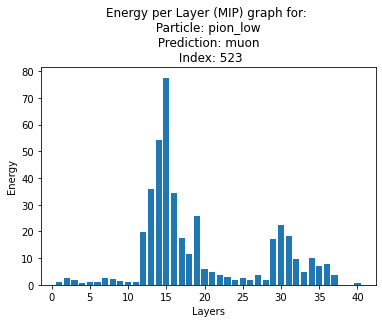

--------------------------------------------------------------------------------------------------------------


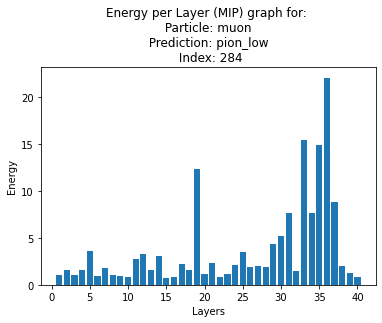

--------------------------------------------------------------------------------------------------------------


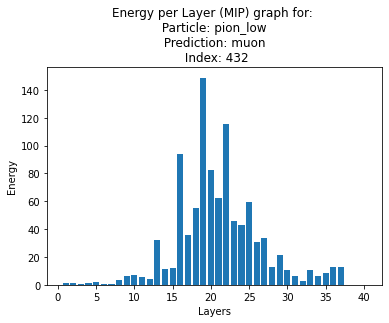

--------------------------------------------------------------------------------------------------------------


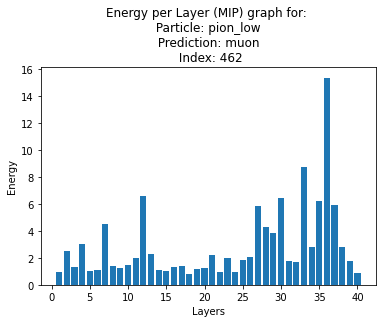

--------------------------------------------------------------------------------------------------------------


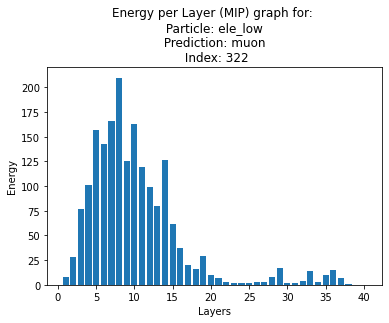

--------------------------------------------------------------------------------------------------------------


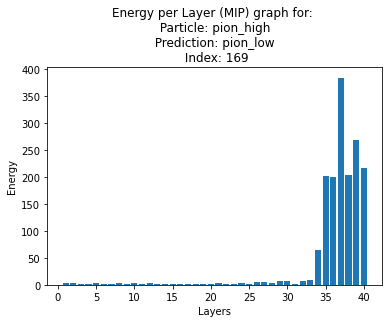

--------------------------------------------------------------------------------------------------------------


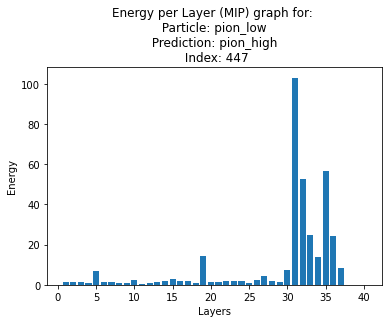

--------------------------------------------------------------------------------------------------------------


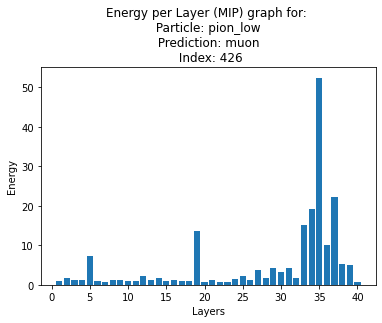

--------------------------------------------------------------------------------------------------------------


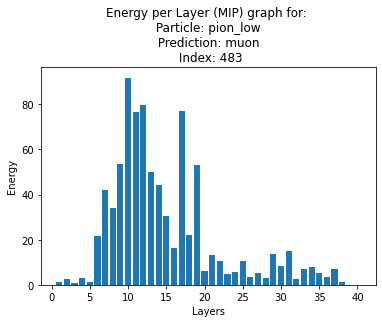

--------------------------------------------------------------------------------------------------------------


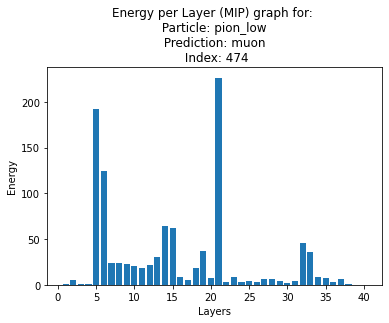

--------------------------------------------------------------------------------------------------------------


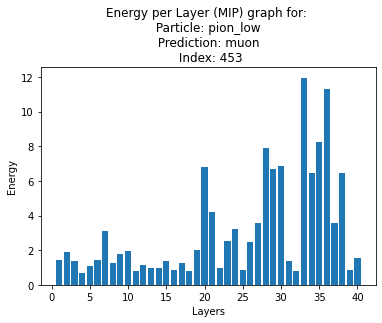

--------------------------------------------------------------------------------------------------------------


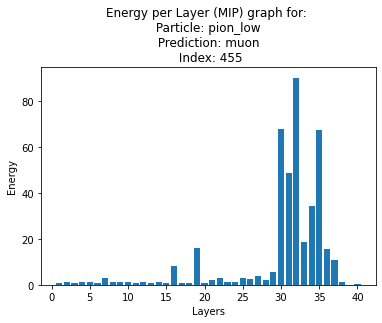

--------------------------------------------------------------------------------------------------------------


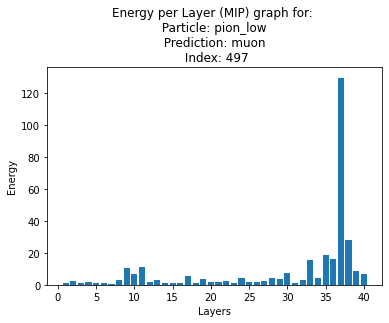

--------------------------------------------------------------------------------------------------------------


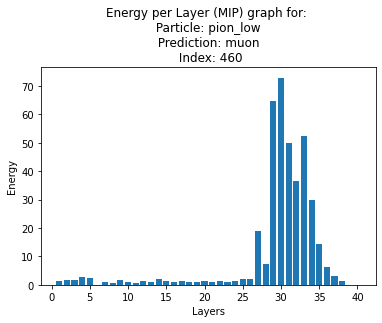

--------------------------------------------------------------------------------------------------------------


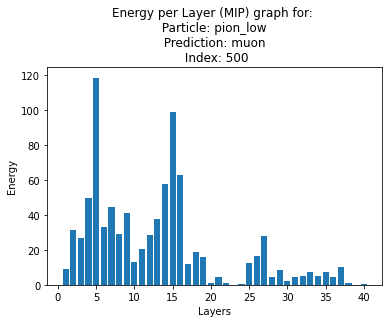

--------------------------------------------------------------------------------------------------------------


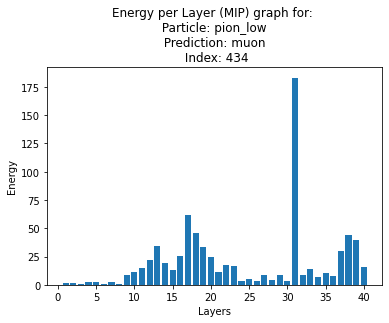

--------------------------------------------------------------------------------------------------------------


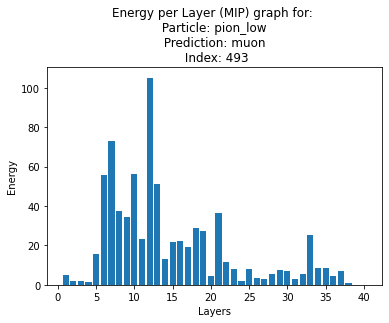

--------------------------------------------------------------------------------------------------------------


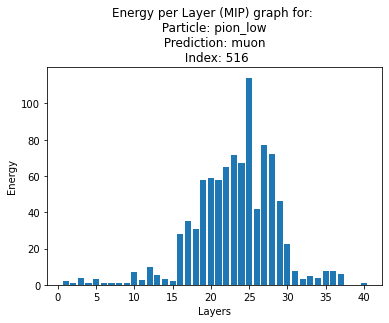

--------------------------------------------------------------------------------------------------------------


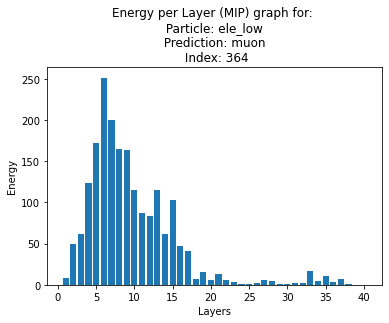

--------------------------------------------------------------------------------------------------------------


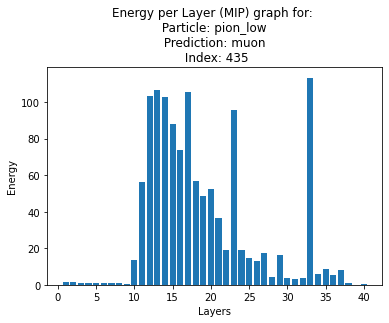

--------------------------------------------------------------------------------------------------------------


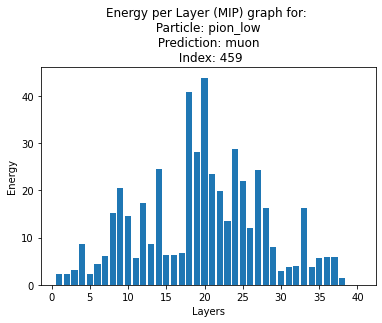

--------------------------------------------------------------------------------------------------------------


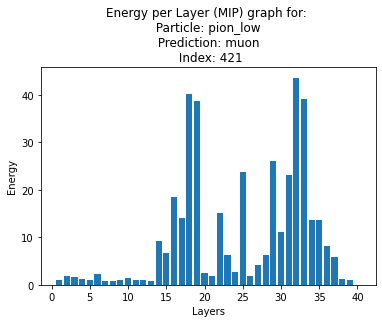

--------------------------------------------------------------------------------------------------------------


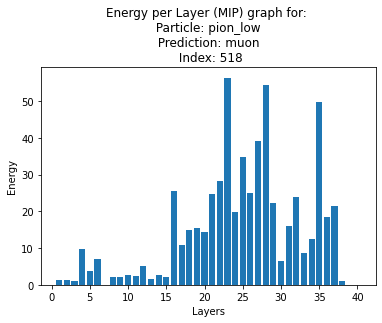

--------------------------------------------------------------------------------------------------------------


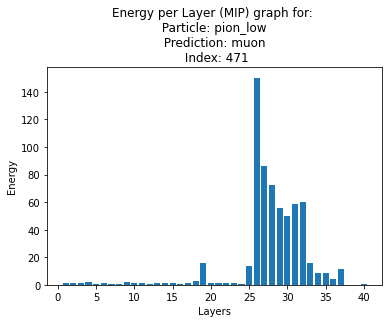

--------------------------------------------------------------------------------------------------------------


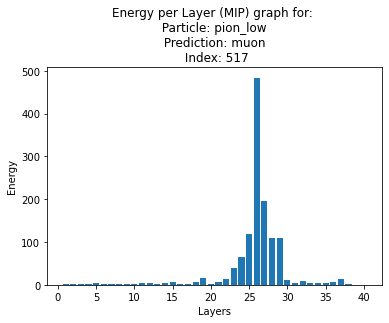

--------------------------------------------------------------------------------------------------------------


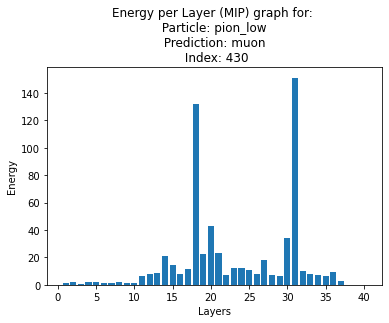

--------------------------------------------------------------------------------------------------------------


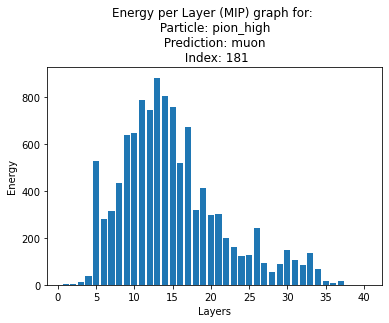

--------------------------------------------------------------------------------------------------------------


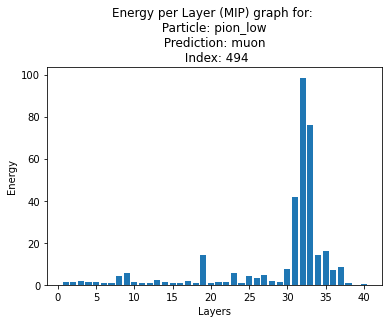

In [113]:
EnergyPlotter(mislabeled_events_df)

### Displaying the importances of the features

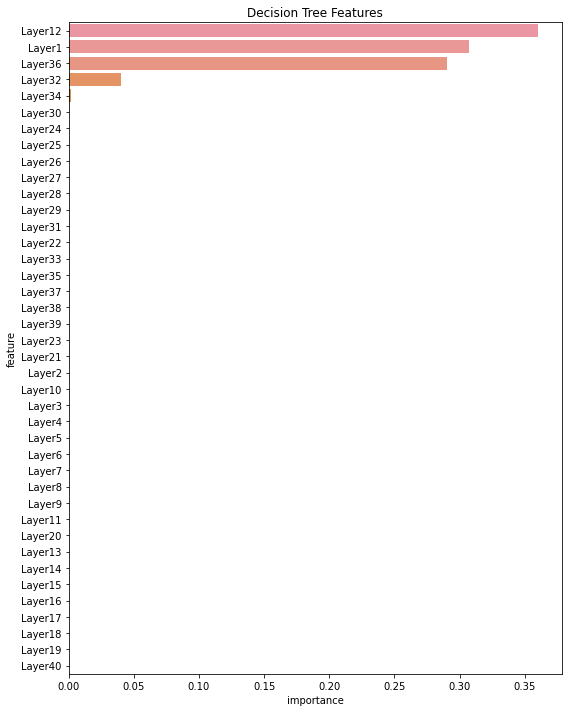

In [114]:
DisplayImportances(feature_importance_df)